In [1]:
import tensorflow as tf
import keras as k
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 8
import h5py
import glob
import cv2
import os

from datetime import date
size = 512
EPOCHS = 10
BATCH_SIZE = 32
BASE_DIR_PATH = '../input/dataset/dataset'
MODEL_FILENAME = 'fruit_classify_model'
PATH_TO_TRAINED_MODEL_FILE = '../working/' + MODEL_FILENAME + '.h5'

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
#build path to base dir
base_dir_path = BASE_DIR_PATH
#build path to train dir
train_dir_path = os.path.join(base_dir_path,'train')
#build path to test dir
test_dir_path = os.path.join(base_dir_path,'test')

def compile_classify_model(num_of_classes):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), input_shape = (size, size, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    #three layers of hidden 

    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Conv2D(256, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Conv2D(512, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(0.25))

    classifier.add(Flatten())

    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dropout(0.25))
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dropout(0.25))
    classifier.add(Dense(units = num_of_classes, activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    #classfier.compile(optimizer = k.optimizers.RMSprop(lr = 1e-4, decay = 1e-6))
    classifier.summary()
    return classifier

def train_classify_model(classify_model, batch_size = BATCH_SIZE, save_model_filename = MODEL_FILENAME, input_size = (size,size)):
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

    test_datagen = ImageDataGenerator(rescale = 1./255)

    training_set = train_datagen.flow_from_directory(train_dir_path,
                                                     target_size = (size, size),
                                                     batch_size = batch_size,
                                                     class_mode = 'categorical')

    test_set = test_datagen.flow_from_directory(test_dir_path,
                                                target_size = (size, size),
                                                batch_size = batch_size,
                                                class_mode = 'categorical')

    callback = [EarlyStopping(monitor='val_loss', patience=5),
                ModelCheckpoint("fruits_checkpoints.h5", monitor='val_loss', save_best_only = True)]
    
    #construct fit generator
    history = classify_model.fit_generator(training_set, epochs=EPOCHS, 
                                       steps_per_epoch = training_set.n // batch_size,
                                       validation_data=test_set,
                                       validation_steps = test_set.n // batch_size,
                                       verbose=1)
    
    class_dict = training_set.class_indices
    np.save('class_dict', class_dict)
    trainedModel_Filename = SaveModelFile(classify_model, save_model_filename)
    return history, trainedModel_Filename


def plot_result(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    return

def SaveModelFile(classify_model, save_model_filename):
    """
    Saves trained classification model

    Args:
        ClassifyModel : trained classification Model
        save_model_filename(str): filename, to save trained model,without extension.

    Returns:
        save_model_filename(str): filename with extension.
    """
    today = date.today()
    #date_str = today.strftime("%d%m%y")
    #save_model_filename = '_'.join([save_model_filename, date_str])
    save_model_filename = save_model_filename + '.h5'
    classify_model.save(save_model_filename)
    print('Done Saving Model File...')
    return save_model_filename

def getTrainedModel(PATH_TO_TRAINED_MODEL_FILE):
    """
    Loads trained-saved model from file(.h5) and returns as a object.

    Args:
        PATH_TO_TRAINED_MODEL_FILE(str): path to saved model file.

    returns:
        trainedModel(model object): returns a model saved as a <.h5>
    """
    trainedModel = load_model(PATH_TO_TRAINED_MODEL_FILE)
    return trainedModel

def getAllClassNames(dir_path):
    """
        Returns list of all class names in given train/test dir path.
    """
    return os.listdir(dir_path)

def readData():
    """
    Console output of,
        total number of classes in train/test dir
        total number of images in train/test dir
    in given dataset.
    
    Returns number of classes
    """
    nb_of_train_files = 0
    nb_of_test_files = 0
    AllClassNames_train = os.listdir(train_dir_path)
    AllClassNames_test = os.listdir(test_dir_path)
    print('Total Number of Classes in train DataSet: ', len(AllClassNames_train))
    print('Total Number of Classes in test DataSet: ', len(AllClassNames_test))
    for class_name in AllClassNames_train:
        nb_of_train_files = nb_of_train_files + len(os.listdir(os.path.join(train_dir_path, class_name)))
        nb_of_test_files = nb_of_test_files + len(os.listdir(os.path.join(test_dir_path, class_name)))
    print('Total Number of train samples: ', nb_of_train_files)
    print('Total Number of test samples:', nb_of_test_files)
    return len(AllClassNames_train)

def understandData(train_or_test):
    """
    Function prints number of images per class in train/test directory
    <CLASS-NAME    NUMBER-OF-IMAGES>

    Args:
        train_or_test(str): directory to select train/test
    """
    train_dir_path = os.path.join(BASE_DIR_PATH, train_or_test)
    # test_dir_path = os.path.join(BASE_DIR_PATH,'test')
    AllClassNames = os.listdir(train_dir_path)
    print("Number of Classes = ", len(AllClassNames))
    # print("Class Names = ",AllClassNames)
    print('CLASS NAME' + '\t' + 'NUMBER OF IMAGES')
    for class_name in AllClassNames:
        print(class_name + '\t', len(os.listdir(os.path.join(train_dir_path, class_name))))
    print("======================================================================")
    # displaySampleImages(train_dir_path,AllClassNames)
    return len(AllClassNames)

def displaySampleImages(PATH_TO_DIR, ALL_CLASS_NAMES):
    """
    Display grid of sample images for every class in dataset.

    Args:
        PATH_TO_DIR(str): path to train or test dir.
        ALL_CLASS_NAMES(str): list of all class names.

    """
    # NoOfClasses = len(ALL_CLASS_NAMES)
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.7, wspace=0.1)
    fig.suptitle('Understanding Fruit-360 Dataset', fontsize=16)
    for n, class_name in enumerate(ALL_CLASS_NAMES):
        ImagePath = glob.glob(os.path.join(PATH_TO_DIR, class_name) + '/*.jpg')[0]
        # print(ImagePath)
        Img = cv2.imread(ImagePath)
        ax = fig.add_subplot(10, 10, (n + 1))
        plt.imshow(cv2.cvtColor(Img, cv2.COLOR_BGR2RGB))
        ax.set_title(class_name)
        plt.axis('off')
    plt.show()
    return

In [3]:
num_of_classes = readData()

Total Number of Classes in train DataSet:  6
Total Number of Classes in test DataSet:  6
Total Number of train samples:  10901
Total Number of test samples: 2698


In [4]:
#Compile classification model
classifyModel=compile_classify_model(num_of_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 510, 510, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 128)       0         
__________

In [5]:
#Start training model on train dataset
training_history,trained_model_path = train_classify_model(classifyModel)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.
Epoch 1/10
340/340 [==============================] - 630s 2s/step - loss: 1.2313 - acc: 0.5022 - val_loss: 0.5952 - val_acc: 0.7961
Epoch 2/10
340/340 [==============================] - 562s 2s/step - loss: 0.5599 - acc: 0.8079 - val_loss: 0.3360 - val_acc: 0.8912
Epoch 3/10
340/340 [==============================] - 566s 2s/step - loss: 0.4196 - acc: 0.8600 - val_loss: 0.2878 - val_acc: 0.8995
Epoch 4/10
340/340 [==============================] - 566s 2s/step - loss: 0.3558 - acc: 0.8768 - val_loss: 0.2620 - val_acc: 0.9104
Epoch 5/10
340/340 [==============================] - 566s 2s/step - loss: 0.2977 - acc: 0.8988 - val_loss: 0.2586 - val_acc: 0.9119
Epoch 6/10
340/340 [==============================] - 567s 2s/step - loss: 0.2677 - acc: 0.9038 - val_loss: 0.2207 - val_acc: 0.9194
Epoch 7/10
340/340 [==============================] - 566s 2s/step - loss: 0.2430 - acc: 0.9172 - val_loss: 0.1398 - 

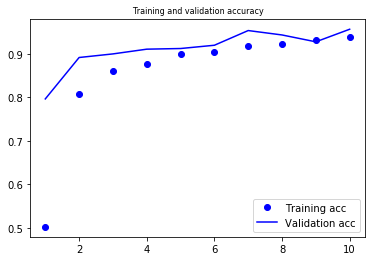

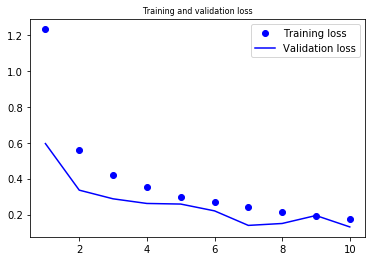

In [6]:
#Plot the training results
plot_result(training_history)

In [7]:
def predictFruitClass(ImagePath, trainedModel, class_dict):
    """
    Perform class prediction on input image and print predicted class.

    Args:
        ImagePath(str): Absolute Path to test image
        trainedModel(object): trained model from method getTrainedModel()
        DictOfClasses(dict): python dict of all image classes.

    Returns:
        Probability of predictions for each class.
    """
    x = image.load_img(ImagePath, target_size=(size,size))
    x = image.img_to_array(x)
    # for Display Only
    import matplotlib.pyplot as plt
    plt.imshow((x * 255).astype(np.uint8))
    x = np.expand_dims(x, axis=0)
    prediction_class = trainedModel.predict_classes(x, batch_size=1)
    prediction_probs = trainedModel.predict_proba(x, batch_size=1)
    print('probs:',prediction_probs)
    print('class_index:',prediction_class[0])
    for key, value in class_dict.items():
        if value == prediction_class.item():
            return key
    return None
    

In [8]:
trained_model_path = PATH_TO_TRAINED_MODEL_FILE
trained_model = getTrainedModel(trained_model_path)
class_dict = np.load('class_dict.npy', allow_pickle=True).item()

probs: [[0. 1. 0. 0. 0. 0.]]
class_index: 1
freshbanana


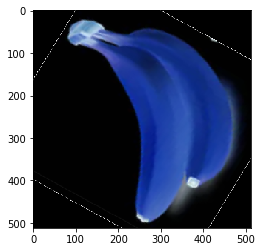

In [9]:
image_path = '../input/dataset/dataset/test/freshbanana/rotated_by_60_Screen Shot 2018-06-12 at 9.56.56 PM.png'
single_pred = predictFruitClass(image_path,trained_model, class_dict)
print(single_pred)